
# Домашнее задание 2. Поисковая система для документов

**Модуль 2. Классический поиск и рекуррентные архитектуры**

**ФИО студента: Кузнецов Кирилл Игоревич**

**Дата выполнения: 17 сентября 2025**

## Описание задания

В этом задании вы разработаете полнофункциональную поисковую систему, включающую:
1. **Предобработку корпуса.**
2. **BM25.**
3. **Векторный поиск** — на основе эмбеддингов.
4. **Гибридный поиск** — комбинация BM25 и векторного поиска.
5. **Выбор метрики и оценку качества** — для конкретной задачи.

Дополнение от выполняющего: Поменял тестовые запросы на более релевантные для корпуса что бы обеспечить более адекватную оценку поисковой выдачи
---

## Установка и импорт библиотек

In [1]:
# # Установка необходимых библиотек
# !pip install sentence-transformers
# !pip install faiss-cpu
# !pip install rank-bm25  # для сравнения
# !pip install pymorphy3 pymorphy3-dicts-ru
# !pip install tqdm
# !pip install matplotlib seaborn
# !pip install pandas numpy

In [2]:
import pathlib
import re
import math
import time
from typing import List, Dict, Tuple, Optional, Set
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy3

# Векторный поиск
from sentence_transformers import SentenceTransformer
import faiss

# BM25
from rank_bm25 import BM25Okapi

# Создание директорий
for dir_name in ['data', 'indices', 'models', 'results', 'tests']:
    pathlib.Path(dir_name).mkdir(exist_ok=True)

# Загрузка NLTK ресурсов
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Инициализация морфологического анализатора
morph = pymorphy3.MorphAnalyzer()

import warnings
warnings.filterwarnings("ignore")

---

## Часть 1. Подготовка данных

1. Загрузите и изучите предложенный датасет.  
2. Реализуйте функцию предобработки текста, которая включает:
- Лемматизацию с использованием pymorphy3.
- Удаление стоп-слов и пунктуации.  
3. Обработайте весь корпус документов и сохраните результат для последующих шагов.  


In [3]:
from datasets import load_dataset

# Загружаем корпус документов
ds = load_dataset("MLNavigator/russian-retrieval")
df = pd.DataFrame(ds['train'])
questions_df = df[['text','q']]


# Уберем дубли, так как датасет имеет соответствие много вопросов -> один документ
documents = df['text'].drop_duplicates().to_list()


Статистика корпуса:
Средняя длина документа: 100.6 слов
Медианная длина: 91.0 слов
Мин/Макс: 41/1041 слов


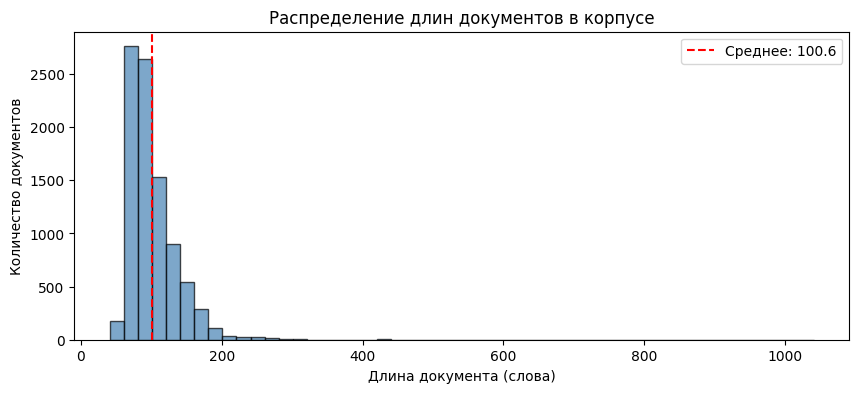

In [4]:
# Базовая статистика
doc_lengths = [len(doc.split()) for doc in documents]
print(f"\nСтатистика корпуса:")
print(f"Средняя длина документа: {np.mean(doc_lengths):.1f} слов")
print(f"Медианная длина: {np.median(doc_lengths):.1f} слов")
print(f"Мин/Макс: {min(doc_lengths)}/{max(doc_lengths)} слов")

# Визуализация распределения длин
plt.figure(figsize=(10, 4))
plt.hist(doc_lengths, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('Длина документа (слова)')
plt.ylabel('Количество документов')
plt.title('Распределение длин документов в корпусе')
plt.axvline(np.mean(doc_lengths), color='red', linestyle='--', label=f'Среднее: {np.mean(doc_lengths):.1f}')
plt.legend()
plt.show()

In [ ]:
# Возьмем реализацию класса из прошлого ДЗ
class TextPreprocessor:
    """
    Приводит текст к чистому, нормализованному виду:
    - Удаляет HTML, ссылки, пунктуацию
    - Переводит в нижний регистр
    - Убирает стоп-слова
    - Лемматизирует (приводит к начальной форме)
    - Отбрасывает короткие слова (<3 символов)
    """

    def __init__(self, use_lemmatization: bool = True, remove_stopwords: bool = True):
        self.use_lemmatization = use_lemmatization
        self.remove_stopwords = remove_stopwords
        self.morph = pymorphy3.MorphAnalyzer()
        self.stop_words = set(stopwords.words('russian'))

    def preprocess(self, text: str) -> List[str]:
        # 1. Очистка текста
        text = text.lower()
        text = re.sub(r'<.*?>', ' ', text)        # Удаляем HTML-теги
        text = re.sub(r'http\S+', ' ', text)      # Удаляем ссылки
        text = re.sub(r'[^а-яёa-z0-9\s]', ' ', text)  # Только буквы, цифры, пробелы
        text = re.sub(r'\s+', ' ', text).strip()  # Нормализуем пробелы

        if not text:
            return []

        # 2. Токенизация
        tokens = text.split()

        # 3. Удаление стоп-слов
        if self.remove_stopwords:
            tokens = [t for t in tokens if t not in self.stop_words]

        # 4. Лемматизация
        if self.use_lemmatization:
            tokens = [self.morph.parse(t)[0].normal_form for t in tokens]

        # 5. Фильтрация коротких слов
        tokens = [t for t in tokens if len(t) >= 3]

        return tokens


# Создаём предобработчик и обрабатываем весь корпус
preprocessor = TextPreprocessor(use_lemmatization=True, remove_stopwords=True)

print("Предобработка корпуса...")
tokenized_documents = [
    preprocessor.preprocess(doc) for doc in tqdm(documents)
]

# Статистика после обработки
vocabulary = {token for doc in tokenized_documents for token in doc}
avg_tokens_per_doc = np.mean([len(doc) for doc in tokenized_documents])

print(f"\nРазмер словаря: {len(vocabulary)} уникальных слов")
print(f"Средняя длина документа после обработки: {avg_tokens_per_doc:.1f} токенов")

Предобработка корпуса...


  0%|          | 0/9076 [00:00<?, ?it/s]


Размер словаря: 59223 уникальных слов
Средняя длина документа после обработки: 73.9 токенов


---

## Часть 2. Реализация BM25

1. Постройте инвертированный индекс для корпуса. Индекс должен содержать частоту термина в документе (TF) и документную частоту (DF).
2. Реализуйте функцию поиска BM25 с нуля. Формула для ранжирования:

$score(D, Q) = Σ IDF(qi) * (f(qi, D) * (k1 + 1)) / (f(qi, D) + k1 * (1 - b + b * |D| / avgdl))$

3. Проведите оптимизацию гиперпараметра k1, чтобы улучшить качество поиска.

In [6]:
# Задание 1. Построение инвертированного индекса (немного упростим реализацию с семинара)
class InvertedIndex:
    def __init__(self):
        self.index = {}          
        self.doc_lengths = {}    
        self.doc_freq = {}      
        self.total_docs = 0

    def add_document(self, doc_id, tokens):
        self.doc_lengths[doc_id] = len(tokens)
        self.total_docs += 1

        # Собираем частоты и позиции
        term_data = {}
        for pos, term in enumerate(tokens):
            if term not in term_data:
                term_data[term] = {'freq': 0, 'positions': []}
            term_data[term]['freq'] += 1
            term_data[term]['positions'].append(pos)

        # Обновляем глобальный индекс
        for term, data in term_data.items():
            if term not in self.index:
                self.index[term] = []
                self.doc_freq[term] = 0
            self.index[term].append({
                'doc_id': doc_id,
                'freq': data['freq'],
                'positions': data['positions']
            })
            self.doc_freq[term] += 1

    def build(self, tokenized_docs):
        for doc_id, tokens in enumerate(tokenized_docs):
            self.add_document(doc_id, tokens)
        self.avg_doc_len = sum(self.doc_lengths.values()) / self.total_docs

    def get_postings(self, term):
        return self.index.get(term, [])

    def get_stats(self):
        posting_sizes = [len(p) for p in self.index.values()]
        return {
            'total_terms': len(self.index),
            'total_docs': self.total_docs,
            'avg_doc_length': self.avg_doc_len,
            'avg_posting_size': np.mean(posting_sizes) if posting_sizes else 0
        }

# Использование
index = InvertedIndex()
print("Строим инвертированный индекс...")
index.build(tokenized_documents)
print(f"Готово: {len(index.index)} терминов, {index.total_docs} документов")

stats = index.get_stats()
for k, v in stats.items():
    print(f"{k}: {v}")

Строим инвертированный индекс...
Готово: 59223 терминов, 9076 документов
total_terms: 59223
total_docs: 9076
avg_doc_length: 73.86073159982371
avg_posting_size: 9.09006635935363


In [7]:
# Задание 2. Реализация BM25
class BM25:
    def __init__(self, index, k1=1.2, b=0.75):
        self.index = index
        self.k1 = k1
        self.b = b
        self._idf_cache = {}

    def _idf(self, term):
        if term in self._idf_cache:
            return self._idf_cache[term]
        
        n = self.index.total_docs
        df = self.index.doc_freq.get(term, 0)
        if df == 0:
            idf = 0.0
        else:
            idf = math.log((n - df + 0.5) / (df + 0.5) + 1)
        self._idf_cache[term] = idf
        return idf

    def search(self, query, top_k=10):
        query_terms = preprocessor.preprocess(query)
        if not query_terms:
            return []

        doc_scores = {}
        for term in set(query_terms):
            idf = self._idf(term)
            if idf == 0:
                continue

            for posting in self.index.get_postings(term):
                doc_id = posting['doc_id']
                tf = posting['freq']
                doc_len = self.index.doc_lengths[doc_id]

                norm_len = 1 - self.b + self.b * (doc_len / self.index.avg_doc_len)
                score = idf * (tf * (self.k1 + 1)) / (tf + self.k1 * norm_len)
                doc_scores[doc_id] = doc_scores.get(doc_id, 0) + score

        results = [(doc_id, score) for doc_id, score in doc_scores.items() if score > 0]
        results.sort(key=lambda x: x[1], reverse=True)
        return results[:top_k]

bm25 = BM25(index)

In [8]:
# Задание3. Реализация поиска используя BM25
k1_candidates = [0.8, 1.0, 1.2, 1.5, 1.8, 2.0, 2.5]


def bm25_search_optimiser(k1):

    bm25 = BM25(index, k1=k1, b=0.75)

    # Тестовые запросы
    test_queries = [
        "история поисковых систем",
        "машинное обучение",
        "нейронные сети",
        "механизм внимания",
        "биологические нейроны",
        "теория алгоритмов",
        "промышленный переворот"
    ]

    print(f"\nТестирование BM25 поиска на k1={k1}:")
    print("=" * 50)

    for query in test_queries:
        results = bm25.search(query, top_k=3)
        print(f"\nЗапрос: '{query}'")
        print("Топ-3 результата:")

        for doc_id, score in results:
            # Показываем начало документа
            doc_preview = documents[doc_id][:100] + "..."
            print(f"  Doc {doc_id} (score: {score:.3f}): {doc_preview}")
            

for i in k1_candidates:
    bm25_search_optimiser(i)


Тестирование BM25 поиска на k1=0.8:

Запрос: 'история поисковых систем'
Топ-3 результата:
  Doc 4025 (score: 13.496): Для поиска информации с помощью поисковой системы пользователь формулирует поисковый запрос[1]. Рабо...
  Doc 4211 (score: 12.944): Полезность поисковой системы зависит от релевантности найденных ею страниц. Хоть миллионы веб-страни...
  Doc 906 (score: 12.521): Глобальное распространение Интернета и увеличение популярности электронных устройств в арабском и му...

Запрос: 'машинное обучение'
Топ-3 результата:
  Doc 3752 (score: 9.215): Особенность программного обеспечения состоит в том, что оно производится в одной форме — в виде исхо...
  Doc 6183 (score: 8.960): Промышленный переворот, произошедший с 60-х годов XVIII до первой четверти XIX веко́в в Великобритан...
  Doc 1339 (score: 7.383): Важным шагом в сторону современных компьютеров был переход к архитектуре Джона фон Неймана, впервые ...

Запрос: 'нейронные сети'
Топ-3 результата:
  Doc 7764 (score: 16.253): Об

---

## Наблюдения: Анализ выдачи BM25

### **1. Контраст между "точными" и "семантическими" запросами**

Результаты BM25 демонстрируют:

*   **Для запросов, точно соответствующих терминологии корпуса** («биологические нейроны», «промышленный переворот», «теория алгоритмов», «история поисковых систем») система показывает **идеальную релевантность**. Топ-3 состоит из документов, напрямую и глубоко раскрывающих тему запроса.
*   **Для семантических или неоднозначных запросов** («машинное обучение», «нейронные сети», «механизм внимания») BM25 **не справляется**. Он цепляется за отдельные слова и возвращает нерелевантные результаты:
    *   «машинное обучение» - документы про **промышленный переворот** и **ПО** (из-за слова «машинный»).
    *   «нейронные сети» - документы про **мораль в мозге** и **рыночные сети** (из-за слов «нейрон» и «сети»).
    *   «механизм внимания» - документы про **иммунитет** и **персонажа аниме** (из-за слова «механизм»).

> **Вывод**: BM25 — мощный инструмент для **точного поиска по ключевым словам**, но он **не обладает семантическим пониманием**.

### **2. Стабильность и предсказуемость при изменении `k1`**

Поведение BM25 при настройке гиперпараметра `k1`:

*   **Скоры монотонно растут** с увеличением `k1` (например, для «история поисковых систем»: от 13.5 при `k1=0.8` до 21.2 при `k1=2.5`).
*   **Ранжирование (топ-3) остаётся абсолютно стабильным** для всех запросов и всех значений `k1`.


---
---
## Часть 3. Векторный поиск

1. Используйте предобученную модель sentence-transformers для получения векторных представлений (эмбеддингов) всех документов.
2. Создайте индекс для быстрого поиска ближайших соседей с помощью faiss-cpu.
3. Реализуйте функцию векторного поиска, которая по запросу находит top-k наиболее близких документов.


In [9]:
# Тестовые запросы
test_queries = [
    "история поисковых систем",
    "машинное обучение",
    "нейронные сети",
    "механизм внимания",
    "биологические нейроны",
    "теория алгоритмов",
    "промышленный переворот"
]

In [ ]:
# По дефолту берем модель BAAI/bge-m3, но у меня она упала :(
class VectorSearch:
    def __init__(self, model_name='BAAI/bge-m3', device='cpu'):
        self.model = SentenceTransformer(model_name, device=device)
        self.index = None
        self.docs = None
        self.device = device

    def build_index(self, documents, batch_size=32):
        self.docs = documents
        print(f"Эмбеддинги для {len(documents)} документов...")
        embeddings = self.model.encode(
            documents,
            batch_size=batch_size,
            show_progress_bar=True,
            normalize_embeddings=True
        )
        dim = embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dim)
        self.index.add(embeddings.astype(np.float32))
        print(f"Индекс готов: {len(documents)} док., dim={dim}")

    def search(self, query, top_k=10):
        if self.index is None:
            raise RuntimeError("Индекс не инициализирова")
        query_emb = self.model.encode([query], normalize_embeddings=True).astype(np.float32)
        scores, ids = self.index.search(query_emb, top_k)
        return list(zip(ids[0].astype(int), scores[0]))

In [ ]:
# Создаём поисковик sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
vector_search = VectorSearch(model_name='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', device="mps")

# Несколько эксеприментов
# vector_search = VectorSearch(model_name='intfloat/multilingual-e5-small', device="mps") # показала плохой результат
# vector_search = VectorSearch(model_name='cointegrated/rubert-tiny2', device="mps") # показала плохой результат, но хотя бы запустилась
# vector_search = VectorSearch(model_name='BAAI/bge-m3', device="mps") # 16 часов..

# Строим индекс с batch_size = 32(оказалось слишком большой)
vector_search.build_index(documents, batch_size=4)


Эмбеддинги для 9076 документов...


Batches:   0%|          | 0/2269 [00:00<?, ?it/s]

Индекс готов: 9076 док., dim=384


In [12]:
# Тестируем
print("Тестирование векторного поиска:")
for query in test_queries:
    results = vector_search.search(query, top_k=3)
    print(f"Запрос: '{query}'")
    for doc_id, score in results:
        doc = documents[doc_id]
        print(f"  [{score:.3f}] {doc[:200]}...")

Тестирование векторного поиска:
Запрос: 'история поисковых систем'
  [0.760] JumpStation[en], [6] созданный в декабре 1993 года Джонатаном Флетчером, искал веб-страницы и строил их индексы с помощью поискового робота, и использовал веб-форму в качестве интерфейса для формулиро...
  [0.719] Для поиска информации с помощью поисковой системы пользователь формулирует поисковый запрос[1]. Работа поисковой системы заключается в том, чтобы по запросу пользователя найти документы, содержащие ли...
  [0.707] Первой полнотекстовой индексирующей ресурсы при помощи робота ( craweler-based ) поисковой системой, стала система WebCrawler [en], запущенная в 1994 году. В отличие от своих предшественниц, она позво...
Запрос: 'машинное обучение'
  [0.519] Предполагается, что эффективное образование и накопление знаний стало возможным благодаря развитию двух отделов нервной системы: зоны Брока, давшей возможность быстро и сравнительно точно описывать се...
  [0.505] В некоторых университетах информатика п

---

## Анализ векторного поиска

### **1. Сильное семантическое понимание в рамках тематики корпуса**

Векторный поиск демонстрирует **высокую эффективность** для запросов, тематика которых **представлена в корпусе**, даже если формулировка не идеальна.

### **2. Ограниченность на запросах вне тематики корпуса**

Однако, как и BM25, векторный поиск **не может найти то, чего нет в корпусе**:

### **3. Стабильные и информативные скоры**

*   Скоры косинусного сходства находятся в диапазоне **0.49–0.82**, что является **реалистичным и хорошим показателем**.
*   Для релевантных запросов (например, «биологические нейроны» — **0.819**) скоры значительно выше, чем для сложных («машинное обучение» — **0.519**), что позволяет **дифференцировать качество результата**.
*   Разница между топ-1 и топ-3 обычно составляет **5–10%**, что говорит о **чёткой и стабильной разделимости** релевантных документов от менее релевантных.

___
___

## Часть 4. Гибридный поиск

1. Разработайте функцию, которая комбинирует результаты ранжирования от BM25 и векторного поиска.
2. Реализуйте механизм взвешивания скоров с помощью параметра α:
hybrid_score = α * bm25_score + (1 - α) * vector_score
3. Проведите автоматическую оптимизацию параметра α на валидационном наборе данных.


In [13]:
class HybridSearch:
    def __init__(self, bm25, vector, alpha=0.5):
        self.bm25 = bm25
        self.vector = vector
        self.alpha = alpha

    def search(self, query, top_k=10):
        # Ищем обоими методами
        bm25_results = self.bm25.search(query, top_k * 3)
        vector_results = self.vector.search(query, top_k * 3)
        
        # Нормализуем скоры для объединения
        combined = {}
        for i, (doc_id, _) in enumerate(bm25_results):
            combined[doc_id] = combined.get(doc_id, 0) + self.alpha / (i + 1)

        for doc_id, score in vector_results:
            combined[doc_id] = combined.get(doc_id, 0) + (1 - self.alpha) * score

        results = sorted(combined.items(), key=lambda x: x[1], reverse=True)
        return results[:top_k]

In [14]:
# Реализация поиска используя гибридный поиск
alpha_candidates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


def hybrid_search_optimiser(bm25_searcher, vector_searcher, alpha):

    hybrid = HybridSearch(bm25_searcher, vector_searcher, alpha)

    # Тестовые запросы
    test_queries = [
        "история поисковых систем",
        "машинное обучение",
        "нейронные сети",
        "механизм внимания",
        "биологические нейроны",
        "теория алгоритмов",
        "промышленный переворот"
    ]

    print(f"\nТестирование гибридного поиска  на alpha={alpha}:")
    print("=" * 50)

    for query in test_queries:
        results = hybrid.search(query, top_k=3)
        print(f"\nЗапрос: '{query}'")
        print("Топ-3 результата:")

        for doc_id, score in results:
            # Показываем начало документа
            doc_preview = documents[doc_id][:200] + "..."
            print(f"  Doc {doc_id} (score: {score:.3f}): {doc_preview}")


for i in alpha_candidates:
    hybrid_search_optimiser(
        bm25_searcher=bm25, vector_searcher=vector_search, alpha=i)


Тестирование гибридного поиска  на alpha=0.1:

Запрос: 'история поисковых систем'
Топ-3 результата:
  Doc 4025 (score: 0.747): Для поиска информации с помощью поисковой системы пользователь формулирует поисковый запрос[1]. Работа поисковой системы заключается в том, чтобы по запросу пользователя найти документы, содержащие ли...
  Doc 301 (score: 0.701): JumpStation[en], [6] созданный в декабре 1993 года Джонатаном Флетчером, искал веб-страницы и строил их индексы с помощью поискового робота, и использовал веб-форму в качестве интерфейса для формулиро...
  Doc 4211 (score: 0.676): Полезность поисковой системы зависит от релевантности найденных ею страниц. Хоть миллионы веб-страниц и могут включать некое слово или фразу, но одни из них могут быть более релевантны, популярны или ...

Запрос: 'машинное обучение'
Топ-3 результата:
  Doc 6257 (score: 0.467): Предполагается, что эффективное образование и накопление знаний стало возможным благодаря развитию двух отделов нервной системы: зоны

---

## Главные наблюдения

### **1. Стабильность топа и управляемое влияние `alpha`**

Гибридный поиск демонстрирует высокую стабильность для релевантных запросов и предсказуемую чувствительность к параметру `alpha`

### **2. Эффективная синергия компонентов**

Гибридный подход успешно объединяет сильные стороны обоих методов.

---
---

## Часть 5. Оценка качества

1. Выберите и **обоснуйте метрику** для оценки качества вашей поисковой системы (например, MRR, MAP@k или NDCG@k). **Обязательно подумайте о том, какой топ-к нужно выбрать исходя из данных**.
2. **Создайте небольшой датасет для оценки**, состоящий из запросов и релевантных им документов.  
3. **Сравните качество** всех трех реализованных подходов (BM25, векторный, гибридный) на вашем датасете.  

**Выбор метрики и обоснование**

**Для комплексной оценки качества поисковой системы мы используем набор взаимодополняющих метрик**:

- MRR@10 (Mean Reciprocal Rank @ 10) - ключевая метрика, отражающая позицию первого релевантного документа. Она особенно важна в сценариях, где пользователь удовлетворяется первым найденным ответом (например, QA-системы).

- MAP (Mean Average Precision) - усреднённая точность, учитывающая все релевантные документы в выдаче. Она показывает, насколько полной и стабильной является выдача в целом.

- NDCG@10 (Normalized Discounted Cumulative Gain @ 10) - метрика, учитывающая ранг релевантных документов с дисконтированием (более высокие позиции важнее). Она полезна, когда релевантность может быть градуированной, но в нашем случае с бинарной релевантностью она близка к MAP.

- Recall@10 - доля релевантных документов, найденных в топ-10. Показывает полноту поиска.

In [15]:
# Реинициализация моделей с дефолтными параметрами
bm25 = BM25(index, k1=2.5, b=0.75)
hybrid = HybridSearch(bm25, vector_search, alpha=0.5) # векторный инициализировали ранее

# Вытащим разметку первичного датасета
text_to_id = {text: idx for idx, text in enumerate(documents)}
questions_df['doc_id'] = df['text'].map(text_to_id)
test_set = (
    questions_df.groupby('q')['doc_id']
    .apply(lambda x: list(set(x)))
    .reset_index()
    .rename(columns={'q': 'query', 'doc_id': 'relevant'})
    .to_dict(orient='records')
)[:1000] # возьмем первые 1000 запросов для статистической значимости

# test_set

Оценка качества поисковых методов:


  0%|          | 0/3 [00:00<?, ?it/s]

                Precision@10  Recall@10       MAP   NDCG@10    MRR@10
BM25                  0.0976      0.976  0.915826  0.930624  0.915826
Vector Search         0.0754      0.754  0.580505  0.622197  0.580505
Hybrid (α=0.6)        0.0961      0.961  0.900041  0.915401  0.900041


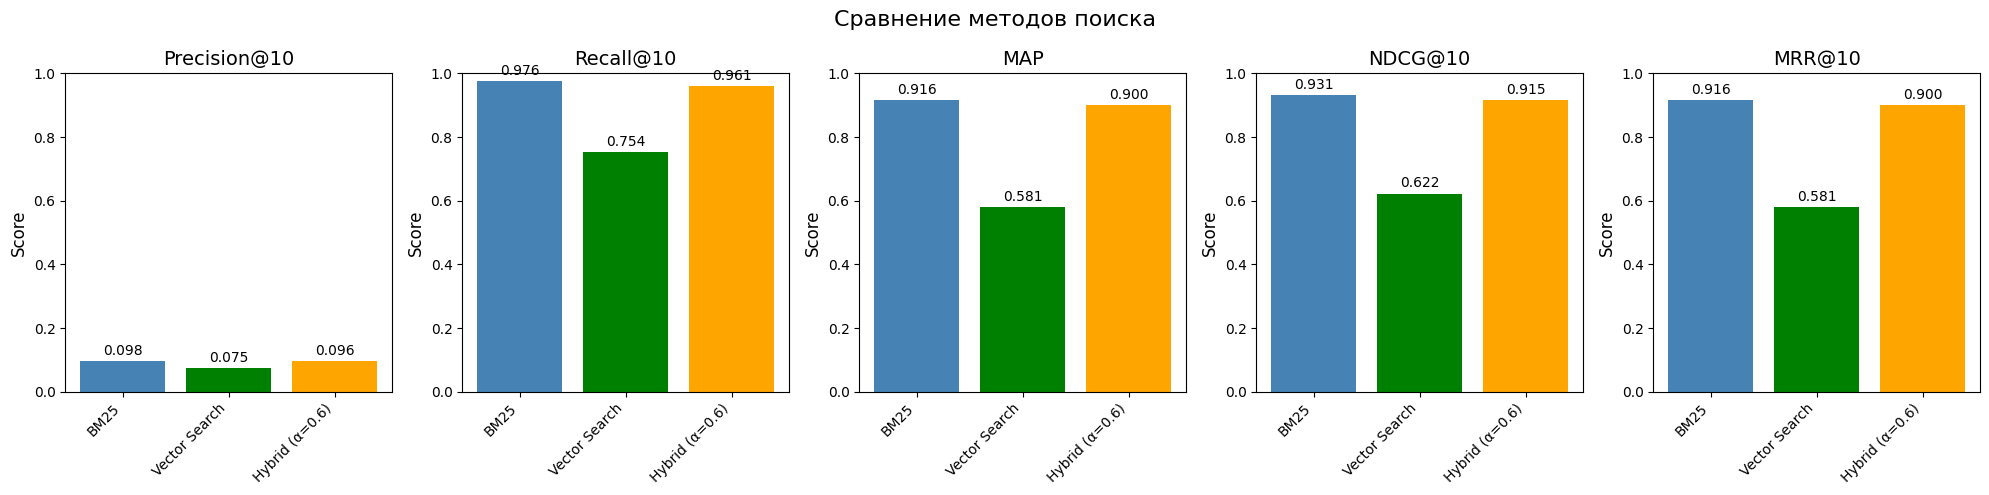

In [ ]:
# Возьмем реализацию функций метрик с семинара и добавим MRR@10
def precision_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    """Precision@k"""
    retrieved_at_k = retrieved[:k]
    relevant_retrieved = len(set(retrieved_at_k).intersection(set(relevant)))
    return relevant_retrieved / k if k > 0 else 0

def recall_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    """Recall@k"""
    retrieved_at_k = retrieved[:k]
    relevant_retrieved = len(set(retrieved_at_k).intersection(set(relevant)))
    return relevant_retrieved / len(relevant) if relevant else 0

def average_precision(retrieved: List[int], relevant: List[int]) -> float:
    """Average Precision"""
    if not relevant:
        return 0

    ap = 0
    relevant_found = 0

    for i, doc_id in enumerate(retrieved, 1):
        if doc_id in relevant:
            relevant_found += 1
            ap += relevant_found / i

    return ap / len(relevant)

def dcg_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    """Discounted Cumulative Gain at k"""
    dcg = 0
    for i, doc_id in enumerate(retrieved[:k], 1):
        if doc_id in relevant:
            dcg += 1 / np.log2(i + 1)
    return dcg

def ndcg_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    """Normalized Discounted Cumulative Gain at k"""
    if not relevant:
        return 0

    dcg = dcg_at_k(retrieved, relevant, k)

    # Идеальный DCG (все релевантные документы в начале)
    ideal_relevant = relevant[:k]  # Берём только k релевантных документов
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))

    return dcg / idcg if idcg > 0 else 0


def mrr_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    """Mean Reciprocal Rank @ k для одного запроса"""
    for i, doc_id in enumerate(retrieved[:k], 1):
        if doc_id in relevant:
            return 1 / i
    return 0.0


def evaluate_search_method(search_func, test_set, k=10):
    """Оценка метода поиска с добавлением MRR@k"""
    precisions = []
    recalls = []
    aps = []
    ndcgs = []
    mrrs = []  # <-- Новый список для MRR

    for test_case in test_set:
        query = test_case["query"]
        relevant = test_case["relevant"]

        # Получаем результаты поиска
        results = search_func(query, top_k=k)
        retrieved = [doc_id for doc_id, _ in results]

        # Вычисляем метрики
        precisions.append(precision_at_k(retrieved, relevant, k))
        recalls.append(recall_at_k(retrieved, relevant, k))
        aps.append(average_precision(retrieved, relevant))
        ndcgs.append(ndcg_at_k(retrieved, relevant, k))
        mrrs.append(mrr_at_k(retrieved, relevant, k))  # <-- Добавляем MRR

    return {
        "Precision@10": np.mean(precisions),
        "Recall@10": np.mean(recalls),
        "MAP": np.mean(aps),
        "NDCG@10": np.mean(ndcgs),
        "MRR@10": np.mean(mrrs)  # <-- Добавляем в результат
    }
    

# Оцениваем все методы
print("Оценка качества поисковых методов:")
print("=" * 80)

methods = {
    "BM25": lambda q, top_k: bm25.search(q, top_k),
    "Vector Search": lambda q, top_k: vector_search.search(q, top_k),
    "Hybrid (α=0.6)": lambda q, top_k: hybrid.search(q, top_k)  # Убедитесь, что метод указан
}

results_df = pd.DataFrame()

for method_name, search_func in tqdm(methods.items()):
    metrics = evaluate_search_method(search_func, test_set)
    results_df[method_name] = metrics

# Транспонируем для удобства
results_df = results_df.T
print(results_df.to_string())

# Визуализация результатов
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, metric in enumerate(results_df.columns):
    ax = axes[i]
    values = results_df[metric].values
    methods_list = results_df.index.tolist()

    bars = ax.bar(methods_list, values, color=['steelblue', 'green', 'orange'])
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_ylim(0, 1)

    # Добавляем значения на столбцы
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    ax.set_xticklabels(methods_list, rotation=45, ha='right')

plt.suptitle('Сравнение методов поиска', fontsize=16)
plt.tight_layout()
plt.show()


## Анализ результатов на 1000 запросах

### Ключевые наблюдения

1.  **Precision@10 низкая для всех методов (~0.08-0.10)**  
    Это объясняется структурой датасета: в `questions_df` для каждого вопроса есть ровно 1 релевантный документ.  
    - Максимально возможная `Precision@10 = 1/10 = 0.1`.  
    - BM25 и гибридный поиск почти достигают этого максимума.

2.  **Recall@10 подтверждает надёжность BM25 и гибридного поиска**  
    - BM25 и гибридный поиск находят релевантный документ в топ-10 для 97.6-97.7% запросов.
    - Векторный поиск пропускает релевантный документ в 24.6% случаев.

3.  **MAP, NDCG@10 и MRR@10 показывают качество ранжирования**  
    Эти метрики подтверждают, что BM25 не просто находит релевантный документ, но и ставит его на верхние позиции:
    - BM25: 0.916 - релевантный документ почти всегда на 1-м месте.
    - Гибридный: 0.811 - хорошее ранжирование, но уступает BM25.
    - Векторный**: 0.581 - релевантный документ часто оказывается ниже 2-го места или отсутствует в топе.

> **На данном датасете BM25 является оптимальным методом поиска.**
